# SETUP

In [1]:
ENCDEC = '../model/ckpt_encdec_e1281.pth'
REFINE = '../model/ckpt_refinement_e1281.pth'

In [2]:
import sys
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
sys.path.insert(0, '../src')
from dataset import SampleDataset
from predict import predict

In [4]:
ds = SampleDataset()

In [5]:
def visualize(dataset, idx, use_trimap):
    fontsize = 18
    
    if(idx == -1):
        idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    mask = sample['mask']
    image = sample['image']
    trimap = sample['trimap']
    
    pmn = predict(image, trimap, '..', use_trimap)
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))

    ax[0, 0].imshow(io.imread(image))
    ax[0, 0].set_title('Input Image idx={}'.format(idx), fontsize=fontsize)
    
    ax[0, 1].imshow(io.imread(trimap))
    ax[0, 1].set_title('Input Trimap', fontsize=fontsize)

    ax[1, 0].imshow(io.imread(mask))
    ax[1, 0].set_title('Ground-Truth Matte', fontsize=fontsize)
    
    ax[1, 1].imshow(pmn)
    ax[1, 1].set_title('Predicted Matte', fontsize=fontsize)

# VISUALIZE

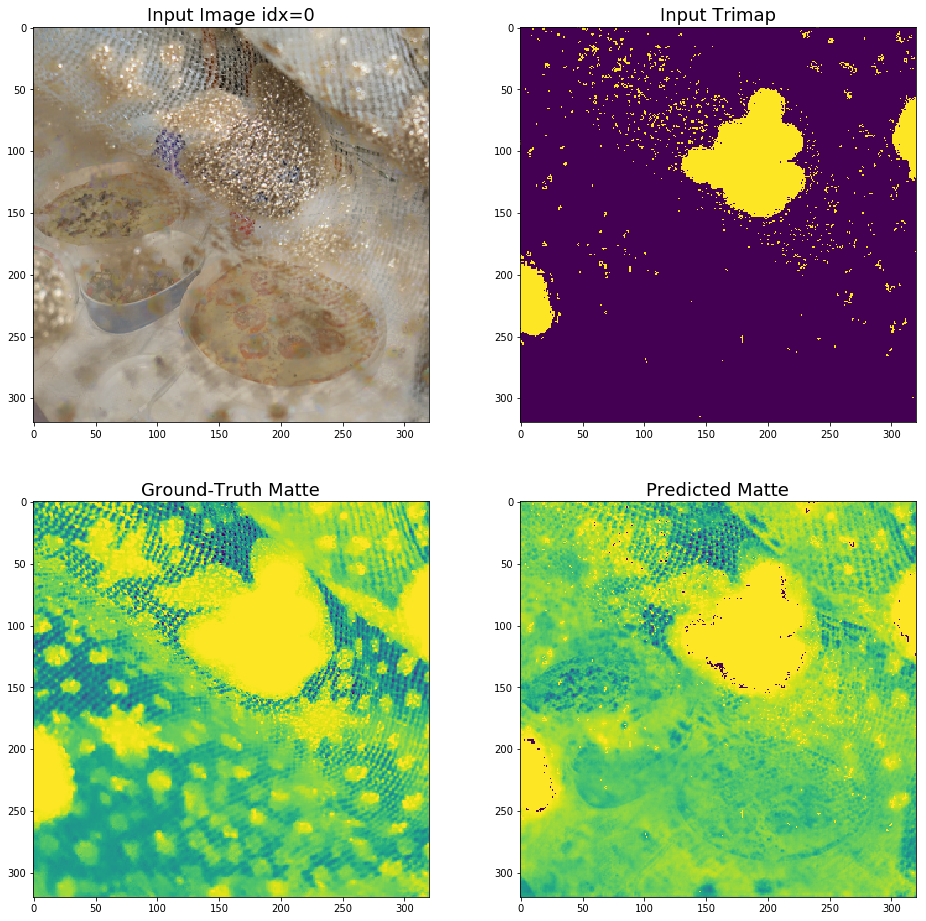

In [10]:
visualize(ds, 0, True)